# Noise2Void - 3D Example

In [1]:
from n2v.models import Config, CARE
import numpy as np
from n2v.utils import plot_some, plot_history
from n2v.utils.n2v_utils import manipulate_val_data

from matplotlib import pyplot as plt

import urllib

import os
import zipfile

Using TensorFlow backend.


## Download Data 
Thanks to Romina Piscitel for letting use use her data.

In [2]:
# Download data
if not os.path.isdir('./data'):
    os.mkdir('./data')

if not os.path.exists('./data/N2V_exampleData3D.zip'):
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/JVxU9uiwM5f0Raz/download', './data/N2V_exampleData3D.zip')
    with zipfile.ZipFile('./data/N2V_exampleData3D.zip', 'r') as zip_ref:
        zip_ref.extractall('./data/N2V_exampleData3D')

## Configure

To use Noise2Void with the CARE framework we have to switch the <code>train_scheme</code> from <code>'CARE'</code> to <code>'Noise2Void'</code>. This will turn on the pixel-masking which is needed for Noise2Void training. Furhtermore it is recommended to increase the <code>train_batch_size</code> and enable <code>batch_norm</code>. 

To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels we manipulated <code>n2v_num_pix</code> = 64 pixels simultaniously. 

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

In [3]:
config = Config('SZYXC', n_channel_in=1, n_channel_out=1, unet_kern_size = 3, train_steps_per_epoch=100, train_loss='mse',
                batch_norm = True, train_scheme = 'Noise2Void', train_batch_size = 4, n2v_num_pix = 2048,
                n2v_patch_shape = (32, 64, 64), n2v_manipulator = 'uniform_withCP', n2v_neighborhood_radius='5',
                train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0},
                train_epochs=100)

In [4]:
vars(config)

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0},
 'batch_norm': True,
 'train_scheme': 'Noise2Void',
 'n2v_num_pix': 2048,
 'n2v_patch_shape': (32, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': '5'}

In [5]:
model = CARE(config=config, name='n2v_3D', basedir='models')

## Training Data Preparation

For training we load __one__ set of low-SNR images and normalize them to 0-mean and 1-std. This data is used as input data and stored in the variable <code>X</code>. Our target <code>Y</code> is <code>X</code> concatenated with a zero-tensor of the same shape. This zero-tensor is used for the masking of the pixels during training. 

In [6]:
# We need to normalize the data before we feed it into our network, and denormalize it afterwards.
def normalize(img, mean, std):
    zero_mean = img - mean
    return zero_mean/std

def denormalize(x, mean, std):
    return x*std + mean

In [7]:
# Load the training data
X = np.load('data/N2V_exampleData3D/Fly_train.npy')[...,np.newaxis]
mean, std = np.mean(X), np.std(X)
X = normalize(X, mean, std)

In [8]:
X.shape

(2560, 32, 64, 64, 1)

In [9]:
# We concatenate an extra channel filled with zeros. It will be internally used for the masking.
Y = np.concatenate((X, np.zeros(X.shape)), axis=4)
print(X.shape, Y.shape)

(2560, 32, 64, 64, 1) (2560, 32, 64, 64, 2)


### Validation Data Preparation

There are two possiblities to build the validation set:

1. Training-Data like: Meaning that the validations loss is only computed on a fixed number of manipulated (masked) pixels. This means that we randomly select a fixed number of pixels before training and manipulate them like it is done for the training data during training. 
2. Test-Data like: Meaning that the validation loss is computed on all pixels of the validation set.
The pixels are __not__ manipulated.
This setup is more like the setup during testing.

In our paper we chose *option 1* to have the same loss during validation as during training. But using *option 2* will result in a more stable validation loss since it is computed over __all__ instead of a subset of pixels.

In [10]:
# load the validation data
X_val = np.load('data/N2V_exampleData3D/Fly_val.npy')[...,np.newaxis]
X_val = normalize(X_val, mean, std)

# 1. Option (is not implemented yet for 3D data)

# 2. Option
Y_val = np.concatenate((X_val.copy(), np.ones(X_val.shape)), axis=4)
print(X_val.shape, Y_val.shape)

(256, 32, 64, 64, 1) (256, 32, 64, 64, 2)


## Training

In [11]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100


/home/krull/projects/n2v/Noise2Void/gitrepos/n2v_exp/n2v/utils/n2v_utils.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return patch[slices]


100/100 [==============================] - 56s 565ms/step - loss: 0.9038 - mse: 0.6625 - mae: 0.5156 - val_loss: 0.5466 - val_mse: 0.5466 - val_mae: 0.5666
Epoch 2/100
100/100 [==============================] - 50s 505ms/step - loss: 0.6960 - mse: 0.4266 - mae: 0.4185 - val_loss: 0.6237 - val_mse: 0.6237 - val_mae: 0.6082
Epoch 3/100
100/100 [==============================] - 56s 563ms/step - loss: 0.6776 - mse: 0.4007 - mae: 0.3966 - val_loss: 0.7484 - val_mse: 0.7484 - val_mae: 0.6788
Epoch 4/100
100/100 [==============================] - 55s 547ms/step - loss: 0.6673 - mse: 0.4119 - mae: 0.4030 - val_loss: 0.7950 - val_mse: 0.7950 - val_mae: 0.6954
Epoch 5/100
100/100 [==============================] - 48s 482ms/step - loss: 0.6522 - mse: 0.3623 - mae: 0.3874 - val_loss: 0.7821 - val_mse: 0.7821 - val_mae: 0.6917
Epoch 6/100
100/100 [==============================] - 47s 466ms/step - loss: 0.6480 - mse: 0.3604 - mae: 0.3867 - val_loss: 0.7738 - val_mse: 0.7738 - val_mae: 0.6920
Epoc

Epoch 48/100
100/100 [==============================] - 54s 542ms/step - loss: 0.6300 - mse: 0.3790 - mae: 0.3950 - val_loss: 0.6097 - val_mse: 0.6097 - val_mae: 0.6179
Epoch 49/100
100/100 [==============================] - 54s 539ms/step - loss: 0.6215 - mse: 0.3536 - mae: 0.3818 - val_loss: 0.6104 - val_mse: 0.6104 - val_mae: 0.6184
Epoch 50/100
100/100 [==============================] - 55s 546ms/step - loss: 0.6244 - mse: 0.3622 - mae: 0.3848 - val_loss: 0.6148 - val_mse: 0.6148 - val_mae: 0.6208
Epoch 51/100
100/100 [==============================] - 54s 536ms/step - loss: 0.6222 - mse: 0.3658 - mae: 0.3874 - val_loss: 0.6075 - val_mse: 0.6075 - val_mae: 0.6169

Epoch 00051: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 52/100
100/100 [==============================] - 53s 532ms/step - loss: 0.6248 - mse: 0.3865 - mae: 0.3882 - val_loss: 0.6115 - val_mse: 0.6115 - val_mae: 0.6191
Epoch 53/100
100/100 [==============================] - 45s 454ms/step - l

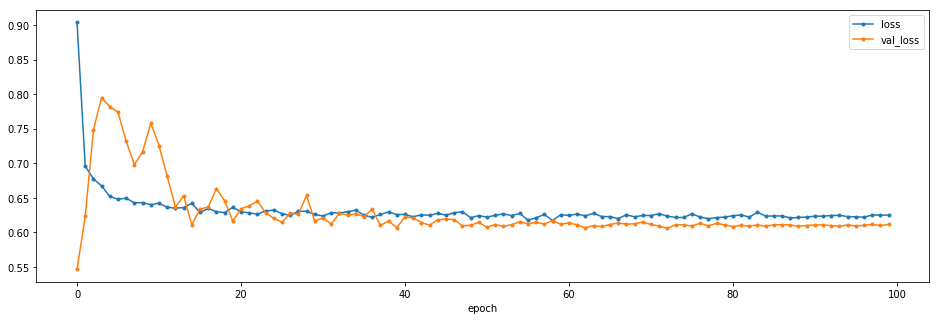

In [63]:
# Lets look at the training and validation loss.

plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

Since we did not manipulate the validation set (choosing *Option 2* above), the validation loss is low in the begining, when the network is close to the identity.

## Evaluation

We do not have ground truth data to calculate a PSNR with this data.
Instead, we will simply look at the denoised images.

In [16]:
# Load the last model.

model.load_weights( name='weights_last.h5')
#model.load_weights( name='weights_now.h5')
#model.load_weights( name='weights_best.h5')

In [13]:
# Load the test data. 
test_lowSNR_raw = np.load('data/N2V_exampleData3D/Fly_test.npy')
test_lowSNR = normalize(test_lowSNR_raw, mean, std)
print(test_lowSNR_raw.shape)

(1, 35, 520, 692)


In [17]:
# Denoise the image. 
predictions = denormalize(model.predict(test_lowSNR[0], axes='ZYX',normalizer=None ), mean, std)
print(predictions.shape)

(35, 520, 692)


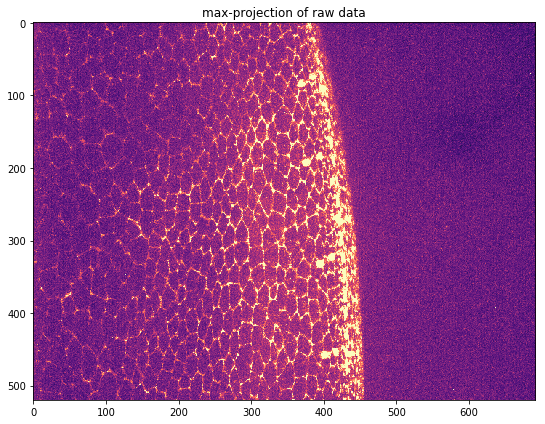

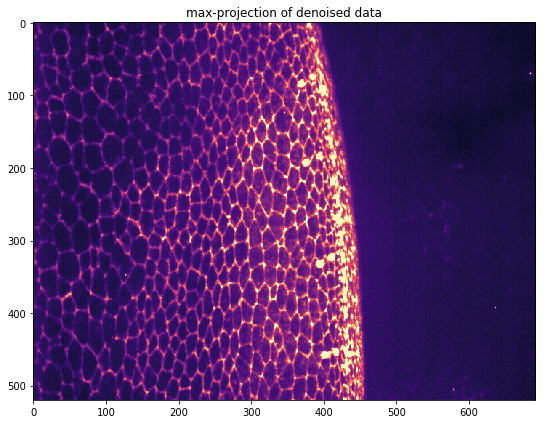

In [58]:
# Lets have a look at the results. 
vmi=np.percentile(predictions,0.1)
vma=np.percentile(predictions,99.95)

plt.figure(figsize=(9,15))
plt.title('max-projection of raw data')
plt.imshow(np.max(test_lowSNR_raw[0],0),vmin=vmi,vmax=vma,cmap="magma")
plt.show()
plt.figure(figsize=(9,15))
plt.title('max-projection of denoised data')
plt.imshow(np.max(predictions,0),vmin=vmi,vmax=vma,cmap="magma")
plt.show()

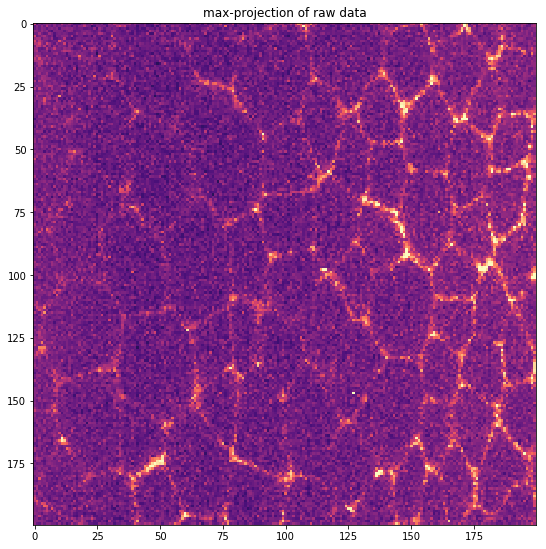

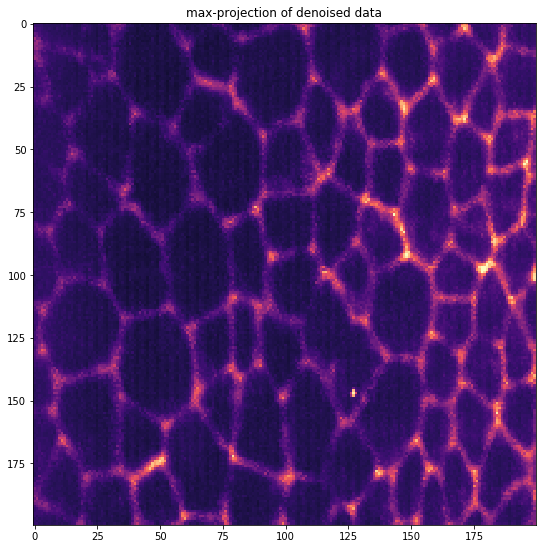

In [62]:
# Let's zoom in 

vmi=np.percentile(predictions,0.1)
vma=np.percentile(predictions,99.95)

plt.figure(figsize=(9,15))
plt.title('max-projection of raw data')
plt.imshow(np.max(test_lowSNR_raw[0,:,200:400,:200,...],0),vmin=vmi,vmax=vma,cmap="magma")
plt.show()
plt.figure(figsize=(9,15))
plt.title('max-projection of denoised data')
plt.imshow(np.max(predictions[:,200:400,:200,...],0),vmin=vmi,vmax=vma,cmap="magma")
plt.show()

In case you wonder about the faint vertical stripes in the background, these are imaging artefacts, revealed by N2V.

See Figure 6 in our paper: https://arxiv.org/pdf/1811.10980.pdf

We can also reveal them in the raw data by doing an average projection:

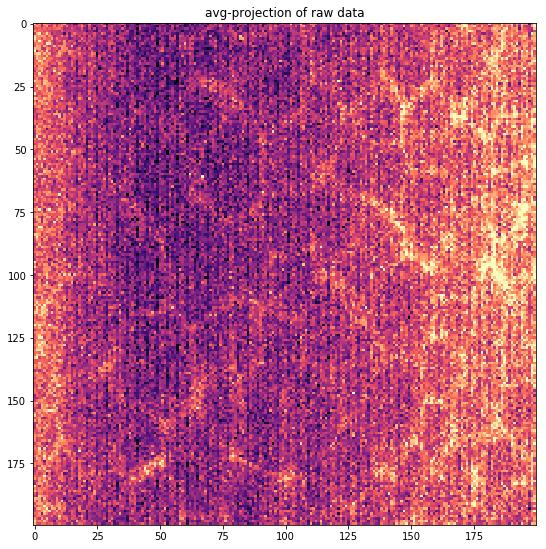

In [57]:
vmi=np.percentile(np.mean(test_lowSNR_raw[0,:,200:400,:200,...],0),0.1)
vma=np.percentile(np.mean(test_lowSNR_raw[0,:,200:400,:200,...],0),99)
plt.figure(figsize=(9,15))
plt.title('avg-projection of raw data')
plt.imshow(np.mean(test_lowSNR_raw[0,:,200:400,:200,...],0),vmin=vmi,vmax=vma,cmap="magma")
plt.show()